# 3. Random FOrest

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_gbq
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from Functions.confusion_matrix import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint

In [ ]:
#Define functions

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
#Call BigQuery

"""
1st - Call bigquery and create new dataset then tables
2nd - Upload jsons to bigquery
3rd - Query the data tables to pull in the necessary information
"""

#1 Call bigquery and create new dataset then tables

#Call BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

#credentials 
credentials = service_account.Credentials.from_service_account_file(
    '*****_credentials.json')

#Project id name
project_id = '*****'

#create the client
client = bigquery.Client(credentials= credentials,project=project_id)

In [3]:
#Import data
sql = """
    SELECT A.sku, A.inventory, A.pieces_past_due, A.min_rec_stock,
      B.sales_1_mon, B.sales_3_mon, B.sales_6_mon,
      C.forecast_3_mon, C.forecast_6_mon,
      D.lead_time, D.potential_issue,
      E.backorder
FROM `backorder_chain_example.inventory` as A
INNER JOIN  `backorder_chain_example.sales`  as B
ON A.sku = B.sku
INNER JOIN `backorder_chain_example.forecast` as C
ON A.sku = C.sku
INNER JOIN `backorder_chain_example.inventory_ordering` as D
ON A.sku = D.sku
INNER JOIN `backorder_chain_example.backorder` as E
ON A.sku = E.sku
  """
start = time.time()

#We will imput the data from the query and re-create the dataframe we created earlier
df = pd.read_gbq(sql, dialect='standard', project_id=project_id)

end = time.time()
print("Query time was " + str(np.round((end-start)/60,2)) + " minutes")

Query time was 2.47 minutes


In [4]:
#Define X and y
y = df['backorder']
X = df.drop(columns=['backorder'])
y_classes = np.array(['no_backorder', 'Backorder'])

#Get training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Get test and dev sets
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

X_train = X_train.drop(columns=['sku'])
test_sku = X_test['sku']
X_test = X_test.drop(columns=['sku'])
dev_sku = X_dev['sku']
X_dev = X_dev.drop(columns=['sku'])

#Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

#Using smote to rebalance data
from collections import Counter

#Import oversampling 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

#Resample
current_count = Counter(y_train)
print(f"Unbalanced count is {current_count}")

X_res, y_res = sm.fit_resample(X_train_std, y_train)

resampled_count = Counter(y_res)
print(f"Rebalanced count is {resampled_count}")

Using TensorFlow backend.


Unbalanced count is Counter({0: 1140175, 1: 59825})
Rebalanced count is Counter({0: 1140175, 1: 1140175})


In [5]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
model = clf.fit(X_res,y_res)

/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Normalized confusion matrix
[[0.98803749 0.01196251]
 [0.76624752 0.23375248]]


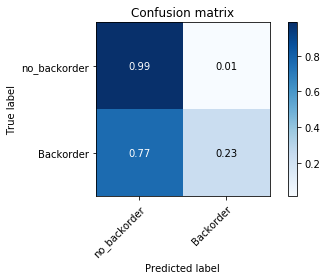

In [6]:
#Test accuracy of X_test
X_dev_std = scaler.transform(X_dev)

y_dev_pred = model.predict(X_dev_std)

# Plot confusion matrix
plot_confusion_matrix(y_dev, y_dev_pred, classes=y_classes, normalize=True, title='Confusion matrix')

plt.show()

In [ ]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 5
best_model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, iid=False)

start = time()
best_model.fit(X_res, y_res)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(best_model.cv_results_)

In [63]:
y_res.shape
X_res.shape

(2280350, 11)

Normalized confusion matrix
[[0.99432061 0.00567939]
 [0.82594308 0.17405692]]


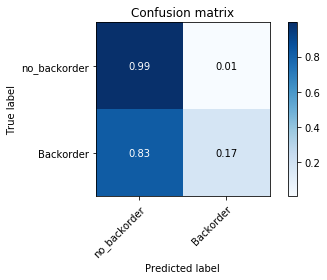

In [59]:
y_dev_pred = best_model.predict(X_dev_std)

# Plot confusion matrix
plot_confusion_matrix(y_dev, y_dev_pred, classes=y_classes, normalize=True, title='Confusion matrix')

plt.show()